In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler


from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 'Company Name', 'Date', 'Open', 'High',
       'Low', 'Close', 'Change', '% Change', 'Volume Traded','Value Traded (SAR)', 'No. of Trades'])

In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [4]:
df.sort_values('Date',inplace=True)

In [5]:

df['Company Name'].unique()[65]

'Saudi Advanced Industries Co.'

In [6]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group                  Company Name                                       
Banks                           Al Rajhi Bank                                          2722
                                Alinma Bank                                            2722
                                Arab National Bank                                     2722
                                Bank Albilad                                           2722
                                Bank Aljazira                                          2722
                                Banque Saudi Fransi                                    2722
                                Riyad Bank                                             2722
                                Samba Financial Group                                  2722
                                Saudi British Bank                                     2722
                                Saudi Investment Bank                                  2

In [7]:
df[df['Industry Group'] == 'Banks']

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
21064,Banks,1090,Samba Financial Group,2009-01-03,50.75,52.00,50.50,50.50,-0.75,-1.46,455859,2.334883e+07,678
26503,Banks,1140,Bank Albilad,2009-01-03,28.10,29.10,28.10,28.30,0.30,1.07,606031,1.736057e+07,612
6059,Banks,1030,Saudi Investment Bank,2009-01-03,16.95,17.75,16.95,17.20,0.65,3.92,160643,2.782922e+06,111
2121,Banks,1010,Riyad Bank,2009-01-03,21.00,21.85,21.00,21.75,0.55,2.59,589847,1.274388e+07,517
15620,Banks,1060,Saudi British Bank,2009-01-03,53.75,57.50,53.75,56.50,2.50,4.62,25475,1.436504e+06,93
12898,Banks,1050,Banque Saudi Fransi,2009-01-03,44.60,47.00,44.60,47.00,1.90,4.21,173113,8.040055e+06,185
23781,Banks,1120,Al Rajhi Bank,2009-01-03,57.00,59.50,57.00,58.50,2.50,4.46,3118489,1.820464e+08,2865
27725,Banks,1150,Alinma Bank,2009-01-03,11.20,11.65,11.20,11.55,0.45,4.05,88413603,1.014294e+09,9448
4843,Banks,1020,Bank Aljazira,2009-01-03,15.10,15.95,15.10,15.95,0.90,5.98,1600168,2.476491e+07,718
18343,Banks,1080,Arab National Bank,2009-01-03,31.00,34.30,31.00,34.20,3.00,9.61,333363,1.124767e+07,370


In [8]:
Riyad_Bank = df[df['Company Name']== 'Jarir Marketing Co.']

In [9]:
Riyadhb_for_model = Riyad_Bank[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [10]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(Riyad_Bank[['Open', 'High', 'Low',
#        'Close', 'Change']])

In [11]:
# scaled_df = pd.DataFrame()

In [12]:
Riyadhb_for_model

,Date,Open,High,Low,Close,Change,% Change
272383,2009-01-03,171.75,174.00,170.50,171.50,-0.50,-0.29
272381,2009-01-04,172.50,172.50,170.00,170.50,-1.00,-0.58
272403,2009-01-05,170.00,171.25,169.00,169.75,-0.75,-0.43
272404,2009-01-06,173.50,179.75,172.25,174.00,4.25,2.50
272402,2009-01-07,173.75,175.25,167.00,168.75,-5.25,-3.01
272399,2009-01-10,164.50,165.50,161.50,162.25,-6.50,-3.85
272397,2009-01-11,165.00,165.00,161.25,161.25,-1.00,-0.61
272398,2009-01-12,161.25,162.00,157.50,158.00,-3.25,-2.01
272396,2009-01-13,157.00,157.00,154.00,156.25,-1.75,-1.10
272393,2009-01-14,156.25,157.75,154.00,155.00,-1.25,-0.80


In [13]:
Riyadhb_for_model.reset_index(inplace=True)

In [14]:
window_len = 5

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(Riyadhb_for_model["Date"][-(227):])[0]

In [15]:
split_date

Timestamp('2019-01-01 00:00:00')

In [16]:
training_set, test_set = Riyadhb_for_model[Riyadhb_for_model['Date'] < split_date], Riyadhb_for_model[Riyadhb_for_model['Date'] >= split_date]


In [17]:
training_set.shape

(2495, 8)

In [18]:
test_set.shape

(227, 8)

In [19]:
training_set.set_index('Date',inplace=True)

In [20]:
test_set.set_index('Date',inplace=True)

In [21]:
# training_target = training_set.pop('Close')

In [22]:
# testing_target = test_set.pop('Close')

In [23]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [24]:
training = training_set.values

In [25]:
testing = test_set.values

In [26]:
testing[0]

array([152.  , 152.  , 151.  , 151.  ,  -1.  ,  -0.66])

In [27]:
test_set[0:1]

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-01-01,152.0,152.0,151.0,151.0,-1.0,-0.66


In [28]:
training_set.tail(10)

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2018-12-18,153.2,154.2,153.0,153.2,-0.6,-0.39
2018-12-19,153.0,153.4,151.8,152.0,-1.2,-0.78
2018-12-20,152.0,152.6,149.8,150.0,-2.0,-1.32
2018-12-23,150.0,151.8,148.2,151.2,1.2,0.80
2018-12-24,152.0,152.8,151.0,152.6,1.4,0.93
2018-12-25,152.6,152.6,151.0,151.4,-1.2,-0.79
2018-12-26,151.0,151.8,150.6,151.4,0.0,0.00
2018-12-27,152.0,152.6,151.0,152.0,0.6,0.40
2018-12-30,153.0,153.0,151.6,152.2,0.2,0.13


In [29]:

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
# LSTM_training_outputs = scaler.transform(LSTM_training_outputs)
# LSTM_training_outputs = np.reshape(LSTM_training_outputs, (len(LSTM_training_outputs),1,1))


LSTM_training_inputs = np.array(LSTM_training_inputs)
# LSTM_training_inputs = scaler.fit_transform(LSTM_training_inputs)
# LSTM_training_inputs = np.reshape(LSTM_training_inputs,(len(LSTM_training_inputs),window_len,1))

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    
    
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
# LSTM_test_outputs = scaler.transform(LSTM_test_outputs)
 
LSTM_test_inputs = np.array(LSTM_test_inputs)
# LSTM_test_inputs = scaler.transform(LSTM_test_inputs)
# LSTM_test_inputs = np.reshape(LSTM_test_inputs,(len(LSTM_test_inputs),window_len,1))

In [30]:
LSTM_test_inputs

array([[[ 1.520e+02,  1.520e+02,  1.510e+02,  1.510e+02, -1.000e+00,
         -6.600e-01],
        [ 1.522e+02,  1.524e+02,  1.518e+02,  1.520e+02,  1.000e+00,
          6.600e-01],
        [ 1.518e+02,  1.526e+02,  1.516e+02,  1.520e+02,  0.000e+00,
          0.000e+00],
        [ 1.520e+02,  1.532e+02,  1.516e+02,  1.532e+02,  1.200e+00,
          7.900e-01],
        [ 1.536e+02,  1.564e+02,  1.520e+02,  1.544e+02,  1.200e+00,
          7.800e-01]],

       [[ 1.522e+02,  1.524e+02,  1.518e+02,  1.520e+02,  1.000e+00,
          6.600e-01],
        [ 1.518e+02,  1.526e+02,  1.516e+02,  1.520e+02,  0.000e+00,
          0.000e+00],
        [ 1.520e+02,  1.532e+02,  1.516e+02,  1.532e+02,  1.200e+00,
          7.900e-01],
        [ 1.536e+02,  1.564e+02,  1.520e+02,  1.544e+02,  1.200e+00,
          7.800e-01],
        [ 1.556e+02,  1.560e+02,  1.538e+02,  1.550e+02,  6.000e-01,
          3.900e-01]],

       [[ 1.518e+02,  1.526e+02,  1.516e+02,  1.520e+02,  0.000e+00,
          0.000e+

In [31]:
LSTM_training_inputs

array([[[ 1.7175e+02,  1.7400e+02,  1.7050e+02,  1.7150e+02,
         -5.0000e-01, -2.9000e-01],
        [ 1.7250e+02,  1.7250e+02,  1.7000e+02,  1.7050e+02,
         -1.0000e+00, -5.8000e-01],
        [ 1.7000e+02,  1.7125e+02,  1.6900e+02,  1.6975e+02,
         -7.5000e-01, -4.3000e-01],
        [ 1.7350e+02,  1.7975e+02,  1.7225e+02,  1.7400e+02,
          4.2500e+00,  2.5000e+00],
        [ 1.7375e+02,  1.7525e+02,  1.6700e+02,  1.6875e+02,
         -5.2500e+00, -3.0100e+00]],

       [[ 1.7250e+02,  1.7250e+02,  1.7000e+02,  1.7050e+02,
         -1.0000e+00, -5.8000e-01],
        [ 1.7000e+02,  1.7125e+02,  1.6900e+02,  1.6975e+02,
         -7.5000e-01, -4.3000e-01],
        [ 1.7350e+02,  1.7975e+02,  1.7225e+02,  1.7400e+02,
          4.2500e+00,  2.5000e+00],
        [ 1.7375e+02,  1.7525e+02,  1.6700e+02,  1.6875e+02,
         -5.2500e+00, -3.0100e+00],
        [ 1.6450e+02,  1.6550e+02,  1.6150e+02,  1.6225e+02,
         -6.5000e+00, -3.8500e+00]],

       [[ 1.7000e+02,  1.7

In [32]:
nn_model.reset_states()
nn_model.reset_metrics()

NameError: name 'nn_model' is not defined

In [33]:

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [34]:
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 511us/step - loss: 159.3421 - val_loss: 145.8198
Epoch 2/120
1992/1992 [==============================] - 1s 254us/step - loss: 151.0073 - val_loss: 138.5262
Epoch 3/120
1992/1992 [==============================] - 0s 251us/step - loss: 145.2716 - val_loss: 133.8233
Epoch 4/120
1992/1992 [==============================] - 1s 272us/step - loss: 140.6079 - val_loss: 129.5524
Epoch 5/120
1992/1992 [==============================] - 1s 281us/step - loss: 136.3915 - val_loss: 125.1889
Epoch 6/120
1992/1992 [==============================] - 1s 262us/step - loss: 131.9459 - val_loss: 120.5063
Epoch 7/120
1992/1992 [==============================] - 1s 278us/step - loss: 127.2257 - val_loss: 115.9631
Epoch 8/120
1992/1992 [==============================] - 1s 272us/step - loss: 122.8648 - val_loss: 111.6945
Epoch 9/120
1992/1992 [==============================] - 1s 273us/step - loss: 11

Epoch 77/120
1992/1992 [==============================] - 1s 281us/step - loss: 5.4156 - val_loss: 2.0756
Epoch 78/120
1992/1992 [==============================] - 1s 287us/step - loss: 5.0658 - val_loss: 1.5689
Epoch 79/120
1992/1992 [==============================] - 1s 286us/step - loss: 5.1960 - val_loss: 1.9561
Epoch 80/120
1992/1992 [==============================] - 1s 283us/step - loss: 5.1831 - val_loss: 1.7863
Epoch 81/120
1992/1992 [==============================] - 1s 282us/step - loss: 4.9100 - val_loss: 1.7460
Epoch 82/120
1992/1992 [==============================] - 1s 283us/step - loss: 5.0407 - val_loss: 2.4186
Epoch 83/120
1992/1992 [==============================] - 1s 275us/step - loss: 4.9726 - val_loss: 1.7403
Epoch 84/120
1992/1992 [==============================] - 1s 279us/step - loss: 4.8371 - val_loss: 1.6341
Epoch 85/120
1992/1992 [==============================] - 1s 281us/step - loss: 4.8476 - val_loss: 1.5297
Epoch 86/120
1992/1992 [======================

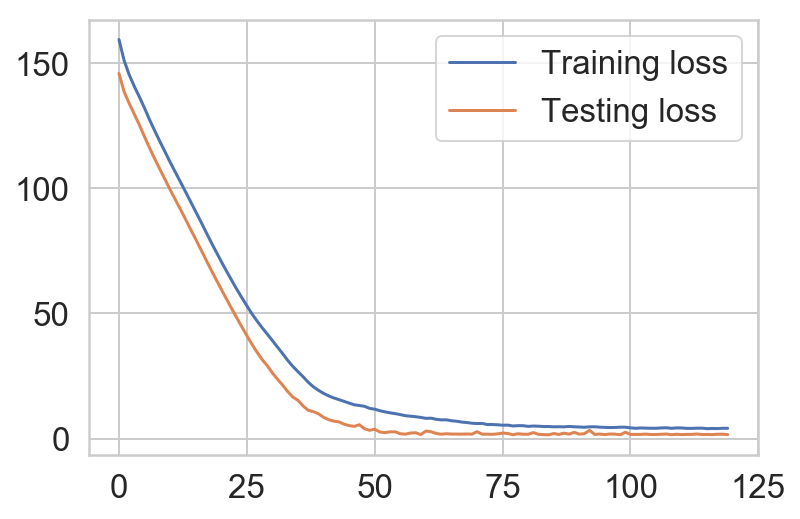

In [35]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

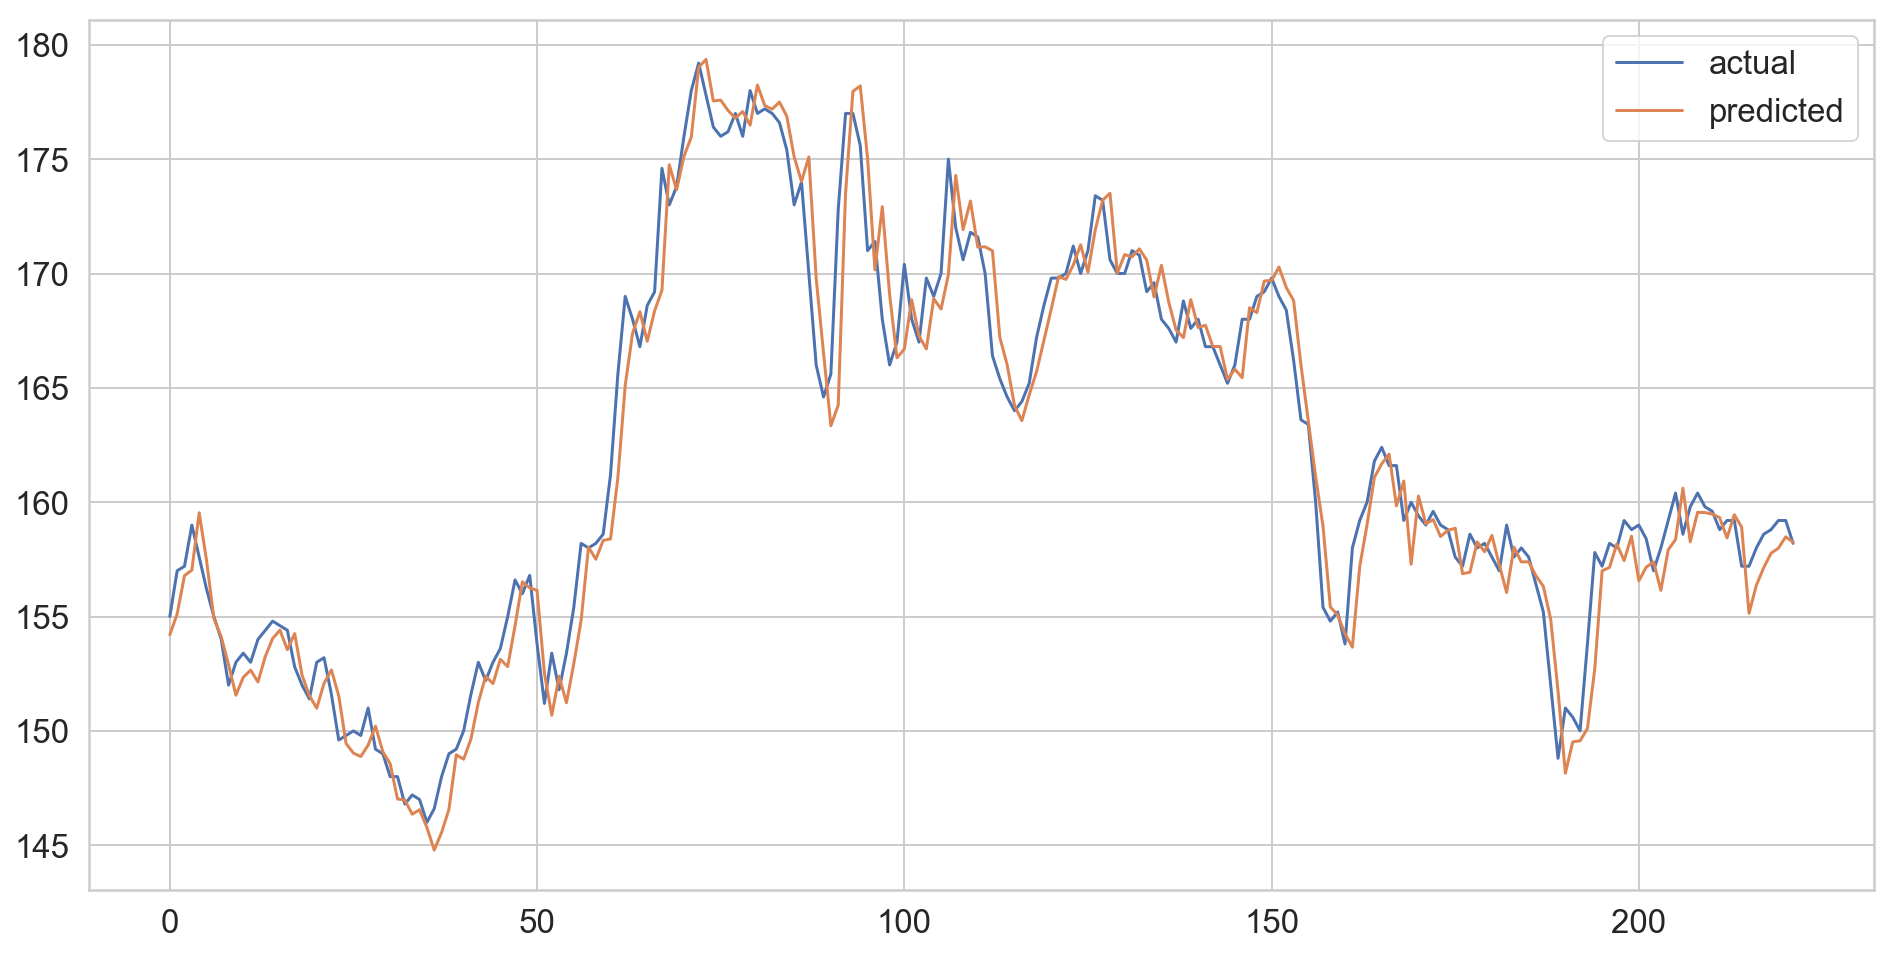

The Mean Absolute Error is: 1.3507431580139708
The Mean squared Error is: 3.35655392204726
The R2 is: 0.9523580887152936


In [37]:
fig = plt.subplots( figsize=(16,8))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
MSE = mean_squared_error(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))
R2_score = r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))
# RMSE = mean_squared_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean squared Error is: {}'.format(MSE))
print('The R2 is: {}'.format(R2_score))
# print('The Mean Root mean squared error) Error is: {}'.format(RMSE))

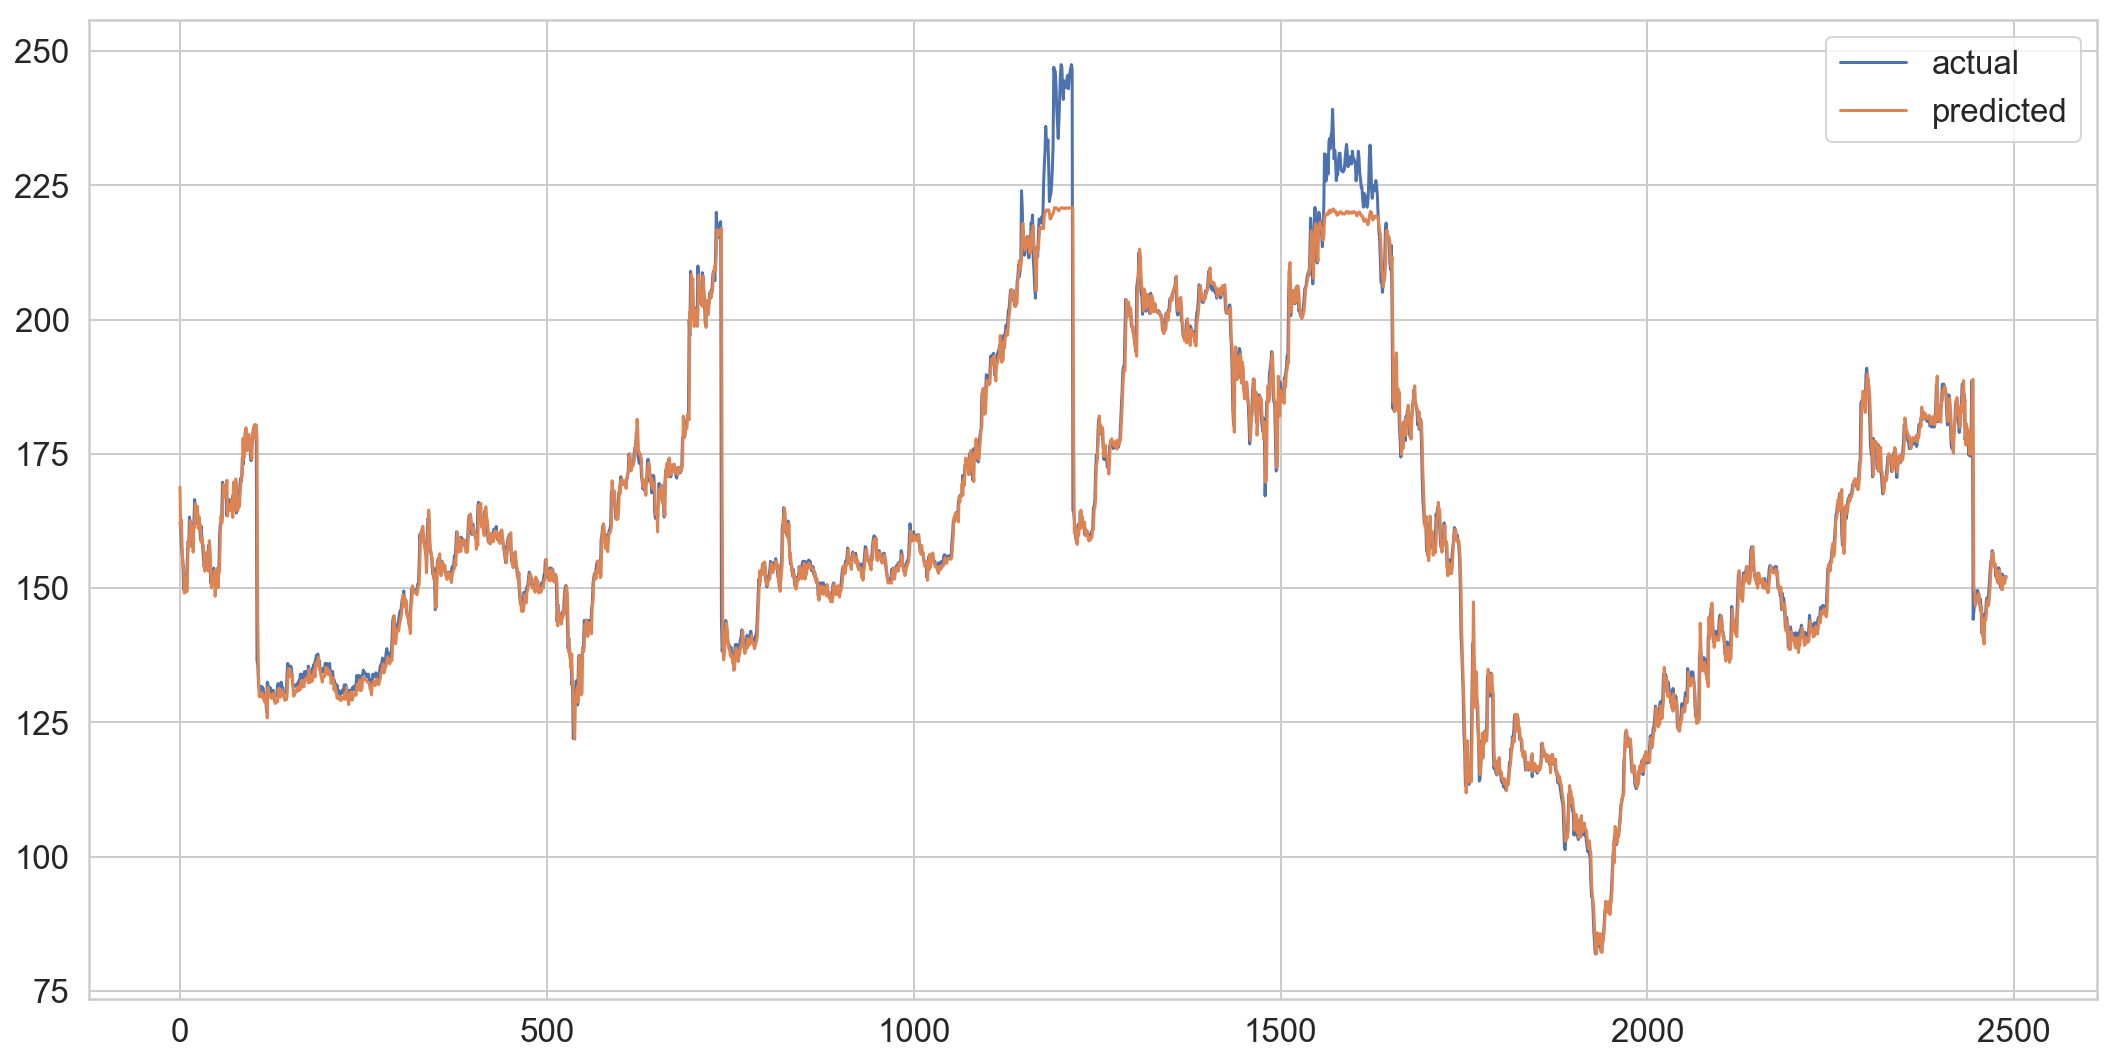

The Mean Absolute Error is: 2.171343433180966
The Mean squared Error is: 19.130169086020622
The R2 is: 0.9799697440752323


In [38]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_training_outputs, nn_model.predict(LSTM_training_inputs))
MSE = mean_squared_error(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))
R2_score = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

print('The Mean Absolute Error is: {}'.format(MAE))
print('The Mean squared Error is: {}'.format(MSE))
print('The R2 is: {}'.format(R2_score))

In [39]:
nn_model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 5, 6),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 400,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': Non

In [40]:
print(nn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               651200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 651,601
Trainable params: 651,601
Non-trainable params: 0
_________________________________________________________________
None
